In [33]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import glob 
import matplotlib.pyplot as plt
import unittest
import math
import os

from moviepy.editor import VideoFileClip

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
index = 1
plt.figure(figsize=(40,100))
img_size=(0,0)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = (img.shape[1], img.shape[0])
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

        #ax = plt.subplot(10,2, index)
        #ax.imshow(img)

        #ax.set_title(fname, fontsize=20)
        index+=1



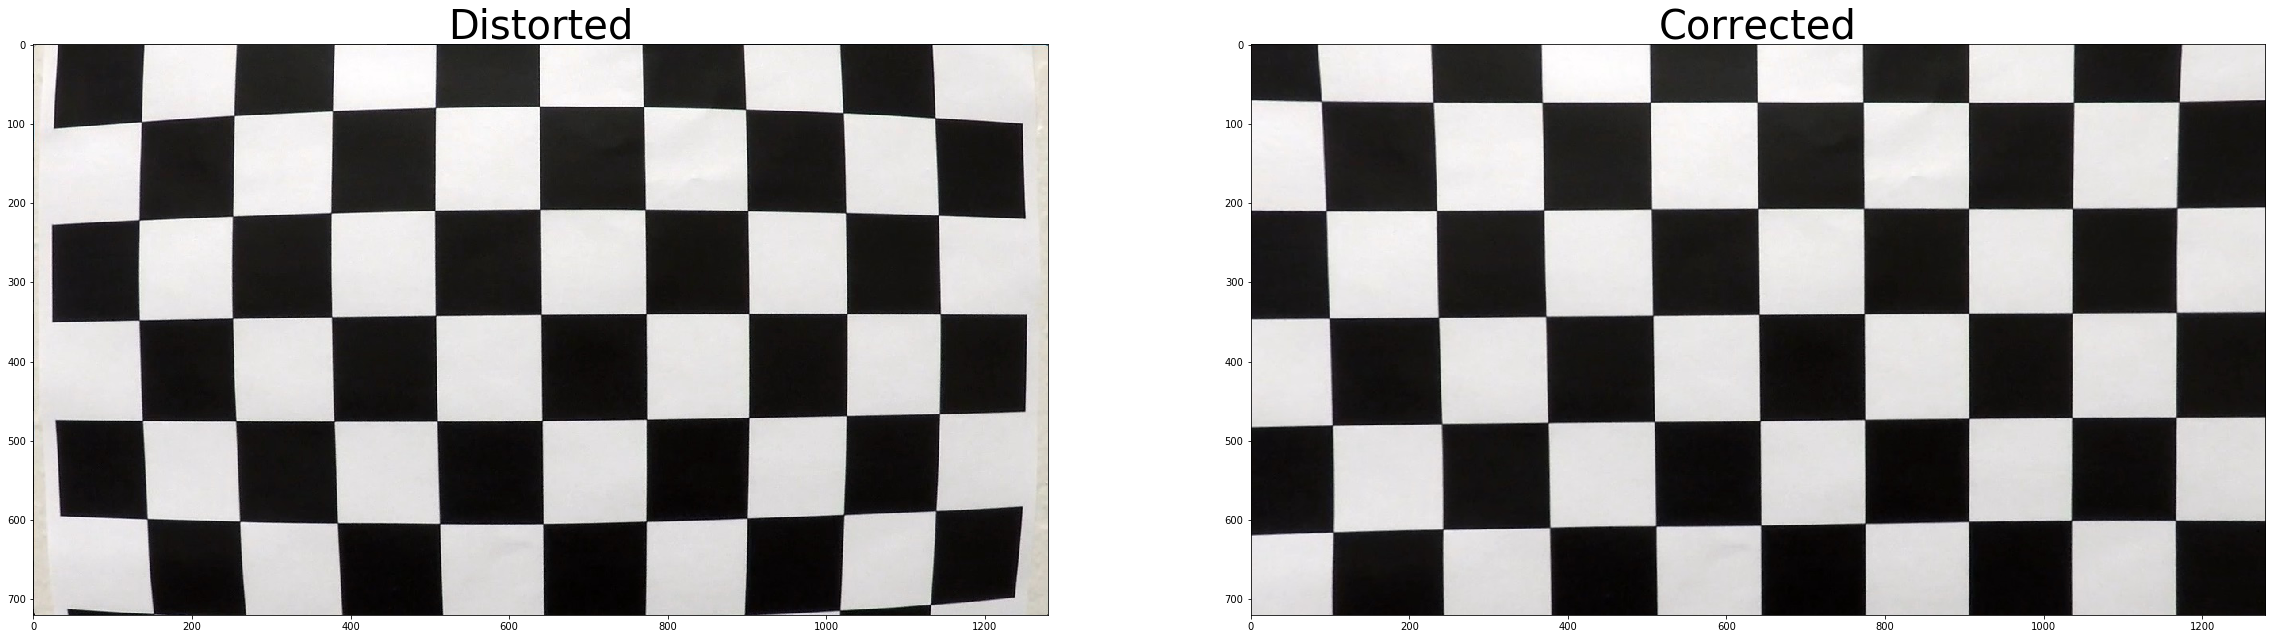

In [34]:


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                         objpoints,
                         imgpoints,
                         img_size,None,None) 

img = mpimg.imread("./camera_cal/calibration1.jpg")
plt.figure(figsize=(40,20))
ax = plt.subplot(1,2,1)
ax.imshow(img)
ax.set_title('Distorted', fontsize=40)
ax = plt.subplot(1,2,2)
ax.imshow(cv2.undistort(img, mtx, dist, None, mtx))
ax.set_title('Corrected', fontsize=40)
plt.savefig('output_images/camera_cal_output.png')

In [35]:
import collections

class Camerapipe:
  window_width = 50 
  window_height = 80 # Break image into 9 vertical layers since image height is 720
  margin = 100 # How much to slide left and right for searching
  def __init__(self, mtx, dist, src, dst ):
    self.mtx = mtx
    self.dist = dist
   # self.src = np.float32([[596,450], [685,450], [205,720], [1105,720]])
   # self.dst = np.float32([[320,0], [870,0], [320,720], [870,720]])
    self.src = src
    self.dst = dst
    self.reset()
    #  right_curverad = time_filter(q_left_curverad,filter_valid_line())
    self.MaxRadius =   100
    self.MinRadius =     0
    self.MaxFilterLength = 15

    pass


  def pipeline(self,img): 
    undistored = self.undistort(img,self.mtx,self.dist)

    binary_combined = self.combined_binary(undistored) 

    (warped,Minv) = self.perspective(binary_combined,self.src,self.dst)

    (img,  leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty) = self.lane_detect(warped)
    (left_curverad, right_curverad) = self.curve_rad_meter( leftx, lefty, rightx, righty, ploty)
    (offset, offset_m) = self.offset( leftx, lefty, rightx, righty, ploty)

    projected_lane = self.projection_lane(warped, undistored, left_fitx, right_fitx, ploty, Minv)
    (filtered_left_radius, filtered_right_radius) = self.radius_filter(left_curverad, right_curverad)
    lane_img = self.draw_lines(img, p.point2lines(self.dst), [1.0,0,0])
    #final_image = self.weighted_img(projected_lane, lane_img, α=0.8, β=1, γ=0)
    return (projected_lane, filtered_left_radius, filtered_right_radius, offset, offset_m)
    #return (img, filtered_left_radius, filtered_right_radius)

  def reset(self):
    self.q_radius_left_right = collections.deque([])

  def weighted_img(self, img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

  def rgb2binary(self,rgb):
    binary = np.sum(rgb, axis=2)
    binary[ binary != 0 ] = 1
    return binary

  def curve_rad_pixel(self, left_fit, right_fit, ploty):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return (left_curverad, right_curverad)

  def offset(self,  leftx, lefty, rightx, righty, ploty):
    IMG_XS = 1280
    IMG_YS = 720
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr  = np.polyfit(lefty , leftx , 2)
    right_fit_cr = np.polyfit(righty, rightx, 2)
    x_l = left_fit_cr[0] *((y_eval)**2)+left_fit_cr[1]* (y_eval)+left_fit_cr[2]
    x_r = right_fit_cr[0]*((y_eval)**2)+right_fit_cr[1]*(y_eval)+right_fit_cr[2]
   
    mid = (x_r + x_l)/2.0
    offset = - (mid - (IMG_XS/2.0))
    offset_m = offset * xm_per_pix
    #print("l=%f, r=%f mid=%f offset=%f offset_m=%f (IMG_XS/2.0)=%f"%(x_l,x_r, mid, offset, offset_m, (IMG_XS/2.0)))
    return (offset, offset_m)

  def curve_rad_meter(self,  leftx, lefty, rightx, righty, ploty):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    #left_fit = np.polyfit(lefty, leftx, 2)  # linear regression for all read pixels (find center line)
    #right_fit = np.polyfit(righty, rightx, 2)

    lefty =  [y * ym_per_pix for y in lefty] 
    leftx =  [x * xm_per_pix for x in leftx] 
    righty = [y * ym_per_pix for y in righty] 
    rightx = [x * xm_per_pix for x in rightx] 

    y_eval = np.max(ploty)
    
    
    # Fit new polynomials to x,y in world space
    left_fit_cr  = np.polyfit(lefty , leftx , 2)
    right_fit_cr = np.polyfit(righty, rightx, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    
    return (left_curverad, right_curverad)
    # Example values: 632.1 m    626.2 m


  def projection_lane(self, warped, undist, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
  #  cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.fillPoly(color_warp, np.int32([pts]), (0,255, 0))

#    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    projected = cv2.addWeighted(undist, 1, newwarp, 0.3, 0) 
    return projected


  def lane_detect(self,binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #print(binary_warped.shape[0]*3/4)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]*3/4):,:], axis=0)
    histogram = np.sum(histogram, axis=1)
    # Create an output image to draw on and  visualize the result
#    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*1.0
    out_img = binary_warped.copy()
   # return (out_img, 0,0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print(histogram[1], midpoint)
    #print(leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    old_good_left_inds = []
    old_good_right_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0.0,1.0,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0.0,1.0,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean  position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
      
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    # leftx, lefty is filtered position only in the searching window
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)  # linear regression for all read pixels (find center line)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

    return (out_img, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty)

  def lane_detect_conv(self,warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
    histogram = np.sum(histogram, axis=1)
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((warped, warped, warped))*1.0

    warped = np.sum(warped.copy(), axis=2)
    #histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
#    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*1.0
    out_img = warped.copy()
    
    window_centroids = self.find_window_centroids(warped, 
        self.window_width, self.window_height, self.margin)

    leftx = []
    lefty = []
    rightx = []
    righty = []

    left_fit = []
    right_fit= []
    left_fitx= []   
    right_fitx=[]
    ploty=[]
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
          (l_mask,l_x,l_y) = self.window_mask(self.window_width,self.window_height,warped,window_centroids[level][0],level)
          (r_mask,r_x,r_y) = self.window_mask(self.window_width,self.window_height,warped,window_centroids[level][1],level)
          leftx.append(l_x)
          lefty.append(l_y)
          rightx.append(r_x)
          righty.append(r_y)
          # Add graphic points from window mask here to total pixels found 
          l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
          r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        out_img = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        left_fit  = np.polyfit(lefty, leftx, 2)  # linear regression for all read pixels (find center line)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
        #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]
     
    # If no window centers found, just display orginal road image
    else:
        out_img = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    return (out_img, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty)

  def find_window_centroids(self,warped, window_width, window_height, margin):
      
      window_centroids = [] # Store the (left,right) window centroid positions per level
      window = np.ones(window_width) # Create our window template that we will use for convolutions
      
      # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
      # and then np.convolve the vertical image slice with the window template 
      
      # Sum quarter bottom of image to get slice, could use a different ratio
      l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
      l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
      r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
      r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
      
      # Add what we found for the first layer
      window_centroids.append((l_center,r_center))
      
      # Go through each layer looking for max pixel locations
      for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
      return window_centroids

  def window_mask(self,width, height, img_ref, center,level):
      output = np.zeros_like(img_ref)
      output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
      plot_y = int(img_ref.shape[0]-(level+0.5)*height)
      return (output, center, plot_y)



  def undistort(self, img, mtx, dist ): 
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

  # Edit this function to create your own pipeline.
  def combined_binary(self, img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    #img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    # HSV, HLS
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = [1.0, 1.0, 1.0]
    return combined_binary

  def point2lines(self,points):
    #-------------------------
    #      
    #      0 -- 1
    #      |    |
    #      2 -- 3
    #      
    #-------------------------
    (x0,y0) = points[0] 
    (x1,y1) = points[1] 
    (x2,y2) = points[2] 
    (x3,y3) = points[3] 
    result = []
    result.append((x0,y0,x1,y1)) 
    result.append((x1,y1,x3,y3)) 
    result.append((x0,y0,x2,y2)) 
    result.append((x2,y2,x3,y3)) 
    return result 

  def draw_lines(self,img, lines, color=[1.0, 0, 0], thickness=2):
    for x1,y1,x2,y2 in lines:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img

  def perspective(self, img, src, dst):
      # Grab the image shape
      img_size = (img.shape[1], img.shape[0])

      # For source points I'm grabbing the outer four detected corners
      #src = np.float32([[600,450], [680,450], [200,700], [1120,700]])
      # For destination points, I'm arbitrarily choosing some points to be
      # a nice fit for displaying our warped result 
      # again, not exact, but close enough for our purposes
      #dst = np.float32([[200,0], [1120,0], [200,700], [1120,700]])

      # Given src and dst points, calculate the perspective transform matrix
      M = cv2.getPerspectiveTransform(src, dst)
      Minv = cv2.getPerspectiveTransform(dst, src)

      # Warp the image using OpenCV warpPerspective()
      warped = cv2.warpPerspective(img, M, img_size)
      return (warped, Minv)
    
  def is_valid_radius(self,left,right):
    
    return 1
    if math.fabs(left-right) > self.MaxRadius :
        return 0
    
    return 1

  def radius_filter(self,left,right):
    return (left,right)    
        
    if self.is_valid_radius(left,right):
        self.q_radius_left_right.append((left,right))

    while(len(self.q_radius_left_right)>self.MaxFilterLength):
        self.q_radius_left_right.popleft()
        
    return self.average_queue(self.q_radius_left_right)

  def average_queue(self,q):
    sum_left = 0.0
    sum_right = 0.0
    count = 0
    for (left, right) in q:
        sum_left += left
        sum_right += right
        count += 1
    #print(sum_left)
    if 0==count : return (0.0, 0.0)
    return (sum_left/count, sum_right/count)

src = np.float32([[596,450], [685,450], [205,720], [1105,720]])
#dst = np.float32([[320,0], [870,0], [320,720], [870,720]])
dst = np.float32([[290,0], [990,0], [290,720], [990,720]])
p = Camerapipe(mtx,dist, src, dst )


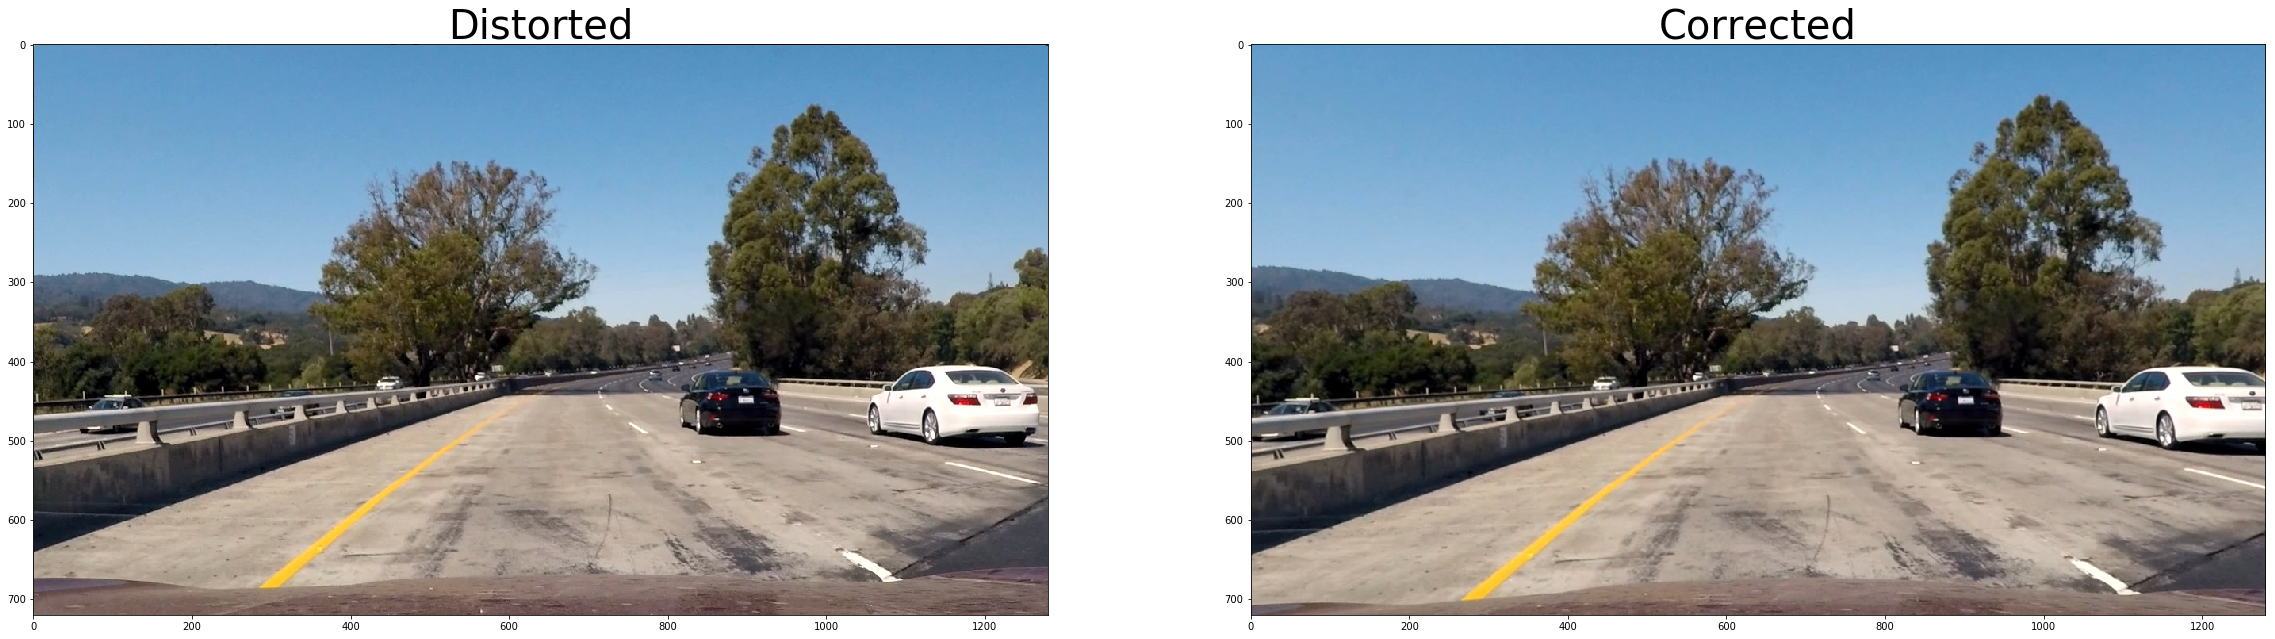

In [36]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
undistorted_img = p.undistort(img,mtx,dist)
plt.figure(figsize=(40,20))
ax1 = plt.subplot(1,2,1)
ax1.imshow(img)
ax1.set_title('Distorted', fontsize=40)
ax2 = plt.subplot(1,2,2)
ax2.imshow(undistorted_img)
ax2.set_title('Corrected', fontsize=40)
plt.savefig('output_images/corrected.png')

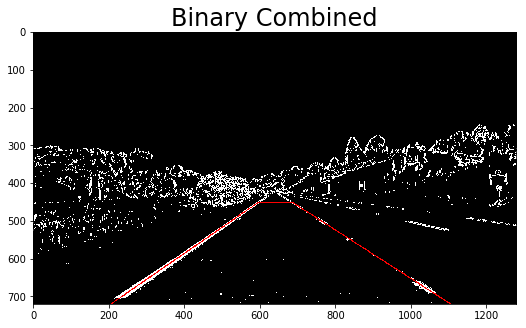

In [37]:
orgimg = mpimg.imread("test_images/straight_lines1.jpg")
binary_combined = p.combined_binary(p.undistort(orgimg,mtx,dist))

plt.figure(figsize=(10,5))
 
binary_combined_red = p.draw_lines(binary_combined.copy(), p.point2lines(src), [1.0,0,0])
plt.imshow(binary_combined_red)

ax3 = plt.subplot(1,1,1)
ax3.set_title('Binary Combined', fontsize=24)
plt.savefig("output_images/combined_binary.png")

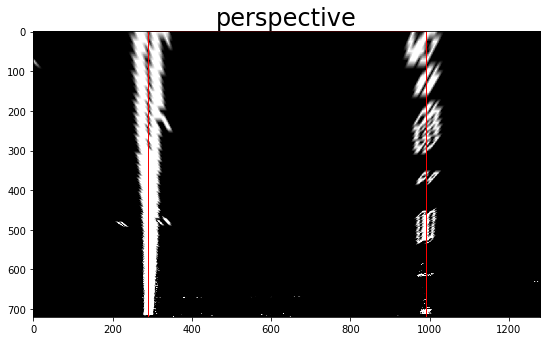

In [38]:
(warped,Minv) = p.perspective(binary_combined,p.src, p.dst)
plt.figure(figsize=(20,10))

ax4 = plt.subplot(1,2,1)

ax4.set_title('perspective', fontsize=24)
ax4.imshow(p.draw_lines(warped.copy(), p.point2lines(dst), [1.0,0,0]))
#ax4.imshow(warped.copy())

plt.savefig("output_images/perspective.png")

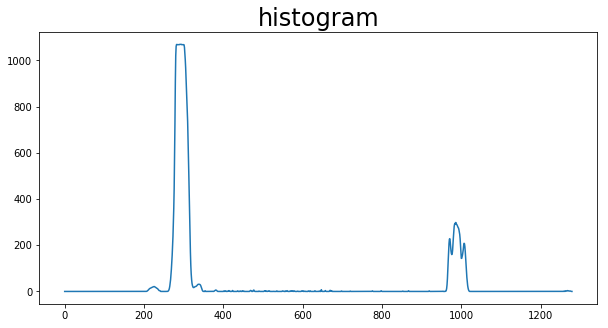

In [39]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
histogram = np.sum(histogram, axis=1)
plt.figure(figsize=(10,5))
ax7 = plt.subplot(1,1,1)
ax7.set_title('histogram', fontsize=24)
ax7.plot(histogram)
plt.savefig("output_images/histogram.png")

31251.7723686 1773.98719538
384.931539015 286.382884317


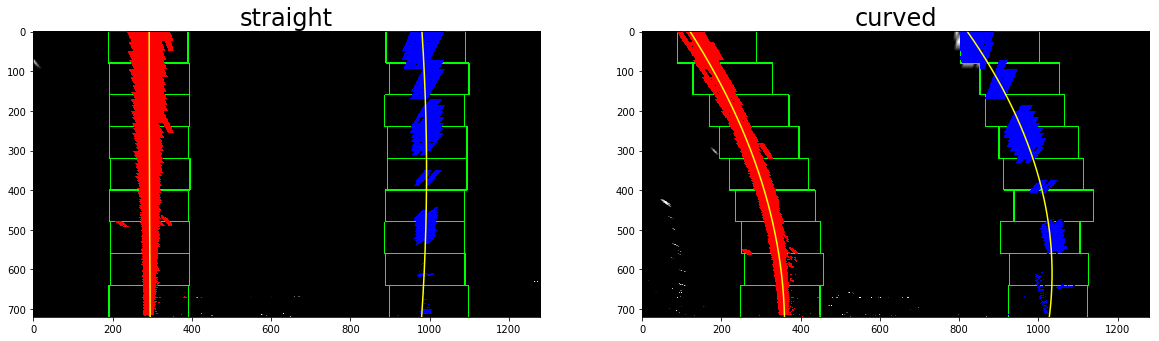

In [40]:

(lane_detect,  leftx, lefty, rightx, righty, left_fit, right_fit, 
      left_fitx, right_fitx, ploty) = p.lane_detect(warped)
plt.figure(figsize=(20,10))
ax5 = plt.subplot(1,2,1)
ax5.set_title('straight', fontsize=24)
ax5.imshow(lane_detect.copy())
ax5.plot(left_fitx, ploty, color='yellow')
ax5.plot(right_fitx, ploty, color='yellow')
(left_curverad, right_curverad) = p.curve_rad_meter( leftx, lefty, rightx, righty, ploty)
print(left_curverad, right_curverad)

curved_orgimg =cv2.imread("test_images/test2.jpg")
imgcurved_orgimg= cv2.cvtColor(curved_orgimg,cv2.COLOR_BGR2RGB)
bcurved_binary_combined = p.combined_binary(p.undistort(curved_orgimg,mtx,dist))
(curved_warped,Minv) = p.perspective(bcurved_binary_combined,p.src, p.dst)
(curved_lane_detect,  leftx, lefty, rightx, righty, left_fit, right_fit, 
      left_fitx, right_fitx, ploty) = p.lane_detect(curved_warped)
ax4 = plt.subplot(1,2,2)
ax4.set_title('curved', fontsize=24)
ax4.imshow(curved_lane_detect)
ax4.plot(left_fitx, ploty, color='yellow')
ax4.plot(right_fitx, ploty, color='yellow')
plt.savefig("output_images/lane_detect.png")

(left_curverad, right_curverad) = p.curve_rad_meter( leftx, lefty, rightx, righty, ploty)
print(left_curverad, right_curverad)


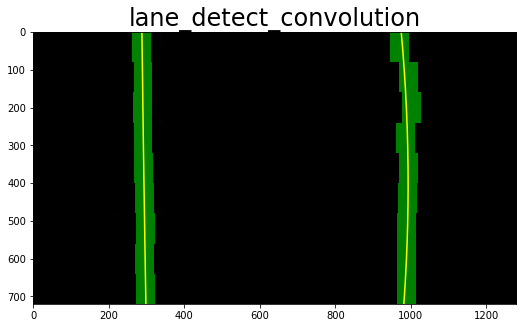

In [41]:

(lane_detect,  leftx, lefty, rightx, righty, left_fit, right_fit, 
      left_fitx, right_fitx, ploty) = p.lane_detect_conv(warped)
plt.figure(figsize=(10,5))
ax8 = plt.subplot(1,1,1)
ax8.set_title('lane_detect_convolution', fontsize=24)
ax8.imshow(lane_detect.copy())
ax8.plot(left_fitx, ploty, color='yellow')
ax8.plot(right_fitx, ploty, color='yellow')
plt.savefig("output_images/lane_detect_convolution.png")

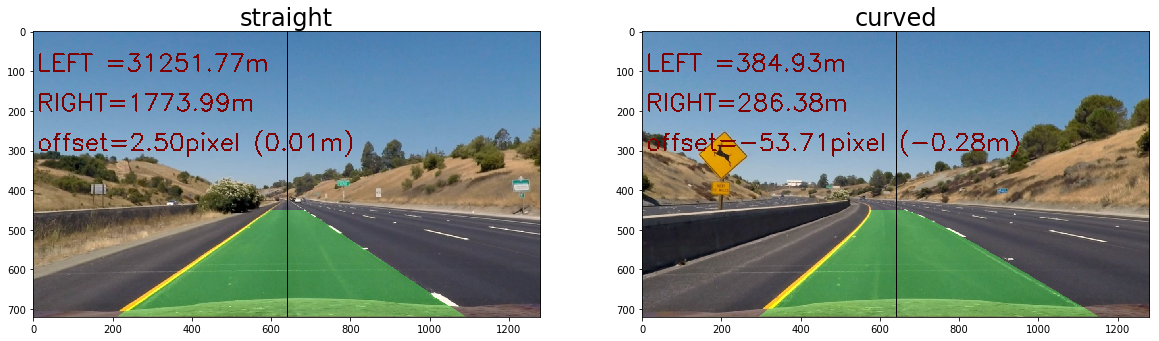

In [42]:

(projected_lane, left_curverad, right_curverad, offset, offset_m) = p.pipeline(orgimg)

cv2.putText(projected_lane,"LEFT =%.2fm"%(left_curverad),  (10,100), cv2.FONT_HERSHEY_SIMPLEX, 2, 128, thickness=3)
cv2.putText(projected_lane,"RIGHT=%.2fm"%(right_curverad), (10,200), cv2.FONT_HERSHEY_SIMPLEX, 2, 128, thickness=3)
cv2.putText(projected_lane,"offset=%.2fpixel (%.2fm)"%(offset, offset_m), (10,300), cv2.FONT_HERSHEY_SIMPLEX, 2, 128, thickness=3)

plt.figure(figsize=(20,10))
ax6 = plt.subplot(1,2,1)
ax6.set_title('straight', fontsize=24)
center_box = np.float32([[1280/2,0], [1280/2,719], [1280/2,719], [1280/2,0]])
ax6.imshow(p.draw_lines(projected_lane.copy(), p.point2lines(center_box), [1.0,0,0]))


curved_image = mpimg.imread("test_images/test2.jpg")
(projected_lane, left_curverad, right_curverad, offset, offset_m) = p.pipeline(curved_image)
cv2.putText(projected_lane,"LEFT =%.2fm"%(left_curverad),  (10,100), cv2.FONT_HERSHEY_SIMPLEX, 2, 128, thickness=3)
cv2.putText(projected_lane,"RIGHT=%.2fm"%(right_curverad), (10,200), cv2.FONT_HERSHEY_SIMPLEX, 2, 128, thickness=3)
cv2.putText(projected_lane,"offset=%.2fpixel (%.2fm)"%(offset, offset_m), (10,300), cv2.FONT_HERSHEY_SIMPLEX, 2, 128, thickness=3)
center_box = np.float32([[1280/2,0], [1280/2,719], [1280/2,719], [1280/2,0]])
ax6 = plt.subplot(1,2,2)
ax6.imshow(p.draw_lines(projected_lane.copy(), p.point2lines(center_box), [1.0,0,0]))
ax6.set_title('curved', fontsize=24)

plt.savefig("output_images/full_output.png")

In [30]:

count = 0
p = Camerapipe(mtx,dist,src,dst)
os.makedirs("./org_frame/",exist_ok=True)
os.makedirs("./out_frame/",exist_ok=True)
def process_image(image):
  global count
  #mpimg.imsave("./org_frame/"+str(count),image)    
  (projected_lane, left_curverad, right_curverad, offset, offset_m) = p.pipeline(image)
  cv2.putText(image,"count=%d"%(count), (10,200), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
  cv2.putText(projected_lane,"LEFT=%.2fm, RIGHT=%.2fm (frame=%d)"%(left_curverad, right_curverad, count), 
                (10,100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
  cv2.putText(projected_lane,"OFFSET=%.2fm"%(offset_m), 
                (10,200), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)

  #mpimg.imsave("./out_frame/"+str(count), projected_lane)    
  count+=1  
  #print(">>>", count)
  return projected_lane





In [32]:
def conv_video(input_filename, output_filename):
  video = VideoFileClip(input_filename)#.subclip(0,1)
  output_video = video.fl_image(process_image) #NOTE: this function expects color images!!
  output_video.write_videofile(output_filename, audio=False)

conv_video("project_video.mp4", './output_images/project_video_output.mp4')

[MoviePy] >>>> Building video ./output_images/project_video_output.mp4
[MoviePy] Writing video ./output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [21:01<00:01,  1.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_output.mp4 

